# Notebook to Investigate LSTM Performance On Test Set A

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from scipy.stats import ttest_ind_from_stats

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:
# Upload Metrics + Snow Class Data created by Notebook "notebooks/Ex3_MultiHucTraining/LSTM_By_Huc_Metric_Download_TestMetrics.ipynb
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "TestA__metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(54, 10)


,huc_id,Name,Test MSE,Test KGE,Test_R2,Predominant_Snow,color_snow_type,mean_elevation,geometry,Elevation Category
0,170103020201,East Fork Pine Creek,0.001897,0.841758,0.924090,Montane Forest,orange,1246.835693,POLYGON ((-116.19050663866074 47.4981031484545...,mid
1,170103020301,Twomile Creek-South Fork Coeur d'Alene River,0.000845,0.924311,0.917509,Montane Forest,orange,1126.706055,POLYGON ((-115.93841588362378 47.5194054160430...,mid


In [5]:
color_map_snow = {
    "Montane Forest": "green", 
    "Maritime": "blue", 
}

In [6]:
#update colors in df_metrics
df_metrics['color_snow_type'] = df_metrics['Predominant_Snow'].map(color_map_snow)
df_metrics.head(2)

,huc_id,Name,Test MSE,Test KGE,Test_R2,Predominant_Snow,color_snow_type,mean_elevation,geometry,Elevation Category
0,170103020201,East Fork Pine Creek,0.001897,0.841758,0.924090,Montane Forest,green,1246.835693,POLYGON ((-116.19050663866074 47.4981031484545...,mid
1,170103020301,Twomile Creek-South Fork Coeur d'Alene River,0.000845,0.924311,0.917509,Montane Forest,green,1126.706055,POLYGON ((-115.93841588362378 47.5194054160430...,mid


In [7]:
def extract_subdict(original_dict, keys_to_extract):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

# Step 2 - Define Plotting And Analytic Functions 

In [8]:
def plot_scatter(df, x_var_name, y_var_name, color_map, title="Scatter_Plot", save_local=True, show_legend=True):
    """
    Creates a scatter plot of specified x and y variables, colored by Predominant Snow Type.

    Parameters:
    - df: DataFrame containing the x and y variables and "color_snow_type" column.
    - x_var_name: Column name for the x-axis variable.
    - y_var_name: Column name for the y-axis variable.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))

    # Use colors directly from the dataframe, default to white if missing
    colors = df["color_snow_type"].fillna("white")

    plt.scatter(df[x_var_name], df[y_var_name], c=colors, alpha=0.7, edgecolors="k")

    # Add labels and title
    plt.xlabel(x_var_name.replace("_", " "))
    plt.ylabel(y_var_name.replace("_", " "))
    plt.title(title.replace("_", " "))

    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
                   for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", bbox_to_anchor=(1.05, 0.5), loc='center left')

    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()




In [9]:
def plot_boxplot_by_group(df, parameter, title, groupby_column, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by a specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column: The column by which to group the data.
    - color_map: A dictionary mapping categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    grouped_data = df.groupby(groupby_column)[parameter].agg(['count', 'mean', 'std', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)])
    #print(f"\nParameter Summary for '{parameter}' by '{groupby_column}':")
    #print(grouped_data, "\n")
    
    # Define a default color map if none is provided
    if color_map is None:
        default_palette = sns.color_palette("husl", len(df[groupby_column].unique()))
        color_map = dict(zip(sorted(df[groupby_column].unique()), default_palette))

    # If category_order is not provided, use the keys of the color_map in order
    if category_order is None:
        category_order = list(color_map.keys())

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette=color_map, order=category_order)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')
        

    # Show the plot
    plt.show()

    return grouped_data







In [10]:
def plot_scatter_w_R2(df, x_var_name, y_var_name, color_map, title="Scatter_Plot", save_local=True, show_legend=True):
    """
    Creates a scatter plot of specified x and y variables, colored by Predominant Snow Type.
    Adds a best-fit line and displays the R-squared value.

    Parameters:
    - df: DataFrame containing the x and y variables and "Snow_Type_Color" column.
    - x_var_name: Column name for the x-axis variable.
    - y_var_name: Column name for the y-axis variable.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))

    # Use colors directly from the dataframe, default to white if missing
    colors = df["color_snow_type"].fillna("white")

    plt.scatter(df[x_var_name], df[y_var_name], c=colors, alpha=0.7, edgecolors="k", label="Data Points")

    # Compute best-fit line
    x_values = df[x_var_name].values.reshape(-1, 1)
    y_values = df[y_var_name].values

    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)

    # Compute R-squared
    r2 = r2_score(y_values, y_pred)

    # Plot best-fit line
    plt.plot(df[x_var_name], y_pred, color="red", linestyle="--", linewidth=2, label=f"Best Fit Line (R²={r2:.2f})")

    # Add labels and title
    plt.xlabel(x_var_name.replace("_", " "))
    plt.ylabel(y_var_name.replace("_", " "))
    plt.title(title.replace("_", " "))

    # Annotate with R-squared value
    plt.text(0.05, 0.9, f"R² = {r2:.2f}", transform=plt.gca().transAxes, fontsize=12, color="red", bbox=dict(facecolor="white", alpha=0.7))

    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
               for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", loc='lower right', bbox_to_anchor=(0.95, 0.05))


    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()


In [11]:
def pairwise_welch_t_test(grouped_data):
    """
    Performs Welch's t-test for unequal variances on all pairwise comparisons 
    of groups in grouped_data.

    Parameters:
    - grouped_data: DataFrame with a 'mean' and 'std' column, indexed by group.

    Returns:
    - A DataFrame with columns "Group1", "Group2", and "P-Value".
    """
    results = []

    # Get unique groups
    groups = grouped_data.index

    # Perform pairwise Welch's t-test
    for group1, group2 in combinations(groups, 2):
        # Extract data for each group
        mean1, std1, n1 = grouped_data.loc[group1, ['mean', 'std', 'count']]
        mean2, std2, n2 = grouped_data.loc[group2, ['mean', 'std', 'count']]

        # Compute Welch's t-test
        t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False)

        # Append results as a row in the list
        results.append({'Group1': group1, 'Group2': group2, 'P-Value': p_value})

    # Convert the results list to a DataFrame
    return pd.DataFrame(results)

In [12]:

def plot_boxplot_by_2group(df, parameter, title, groupby_column_1, groupby_column_2, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column_1: The first column by which to group the data (determines left-to-right order).
    - groupby_column_2: The second column for creating side-by-side box plots within each group of groupby_column_1.
    - color_map: A dictionary mapping groupby_column_2 categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting groupby_column_1.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        unique_categories = sorted(df[groupby_column_2].unique())
        default_palette = sns.color_palette("husl", len(unique_categories))
        color_map = dict(zip(unique_categories, default_palette))

    # If category_order is not provided, use the sorted unique values from groupby_column_1
    if category_order is None:
        category_order = sorted(df[groupby_column_1].unique())

    # Apply truncation if enabled
    if trunc:
        category_order = [cat[:15] for cat in category_order]

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=groupby_column_1, y=parameter, hue=groupby_column_2, 
                palette=color_map, order=category_order, dodge=True)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column_1)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Move the legend outside the plot for better visibility
    plt.legend(title=groupby_column_2, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()



# Step 3 Create ScatterPlots of Evaluation Metrics

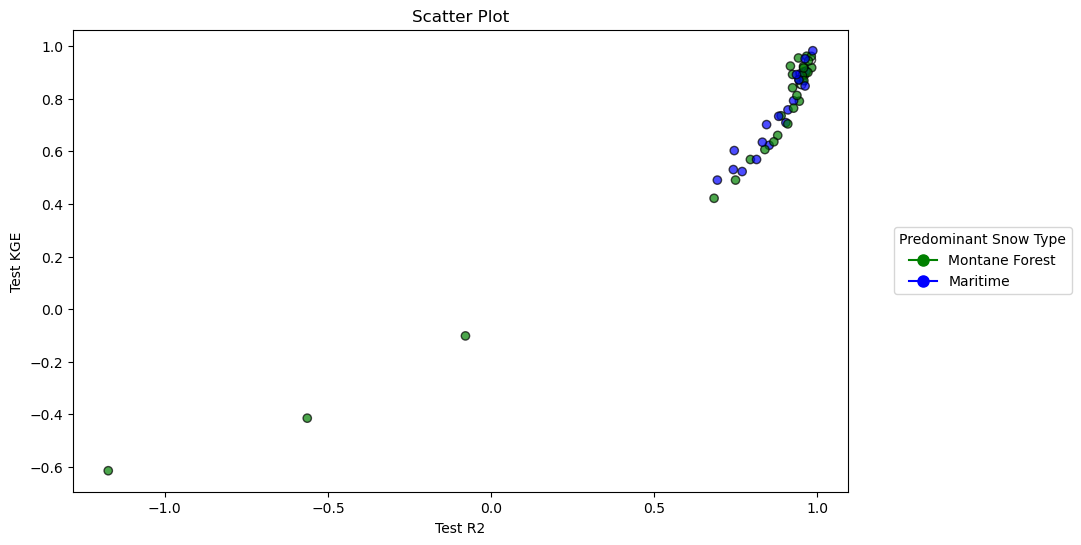

In [13]:
# All results 
plot_scatter(df_metrics, "Test_R2", "Test KGE", color_map_snow)

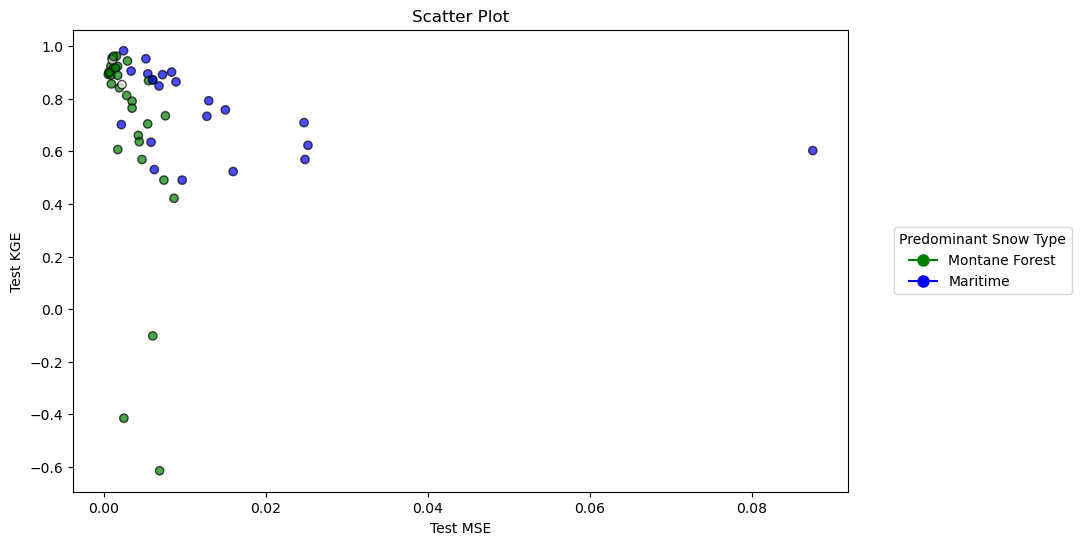

In [14]:
# All results 
plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map_snow)

# Step 5 - Create box and whisker plot 

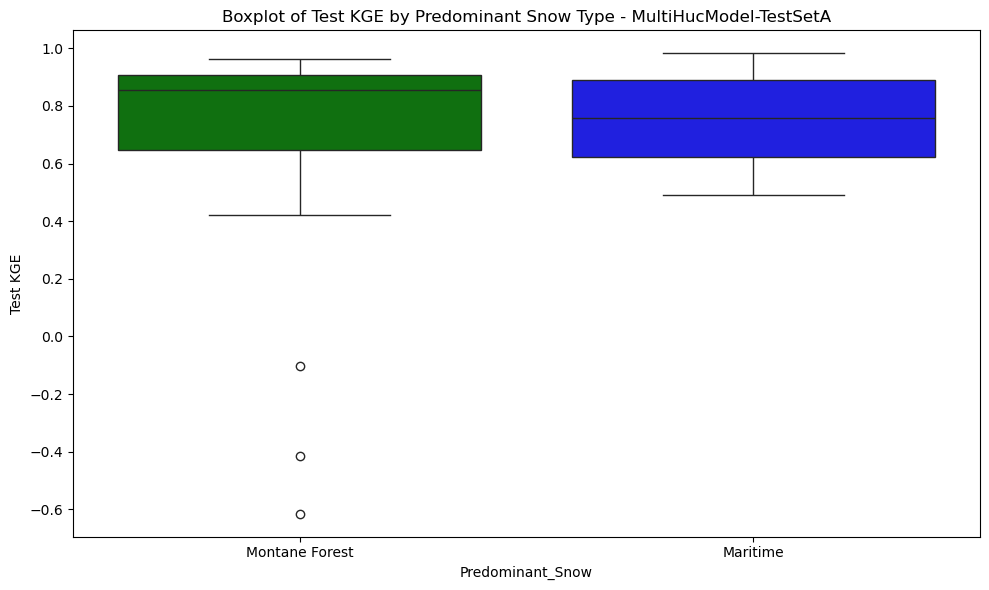

In [15]:
parameter = "Test KGE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel-TestSetA"
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map_snow)



In [16]:
grouped_data

,count,mean,std,<lambda_0>,median,<lambda_1>
Predominant_Snow,,,,,,
Maritime,21,0.751511,0.154504,0.623014,0.757705,0.891789
Montane Forest,31,0.692836,0.389008,0.648500,0.856470,0.908765
Prairie,2,0.900813,0.066511,0.877298,0.900813,0.924328


In [17]:
p_values = pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Maritime,Montane Forest,0.453653
1,Maritime,Prairie,0.108798
2,Montane Forest,Prairie,0.036034


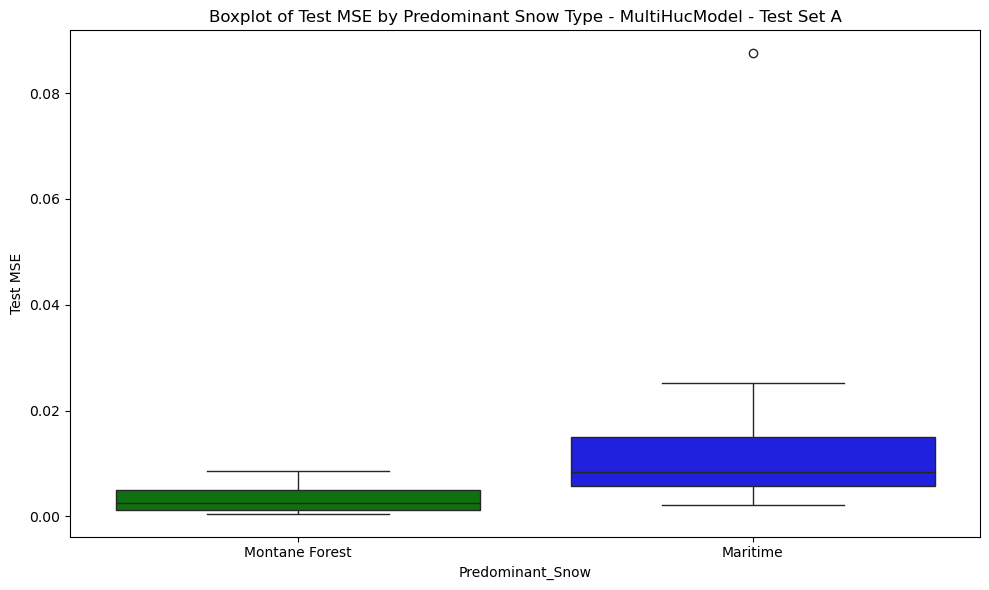

In [18]:
parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel - Test Set A"
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map_snow)

In [19]:
grouped_data

,count,mean,std,<lambda_0>,median,<lambda_1>
Predominant_Snow,,,,,,
Maritime,21,0.014106,0.018272,0.005805,0.008343,0.014987
Montane Forest,31,0.003208,0.002418,0.001181,0.002450,0.005043
Prairie,2,0.001619,0.000847,0.001320,0.001619,0.001919


In [20]:
p_values = pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Maritime,Montane Forest,0.013099
1,Maritime,Prairie,0.005527
2,Montane Forest,Prairie,0.147747


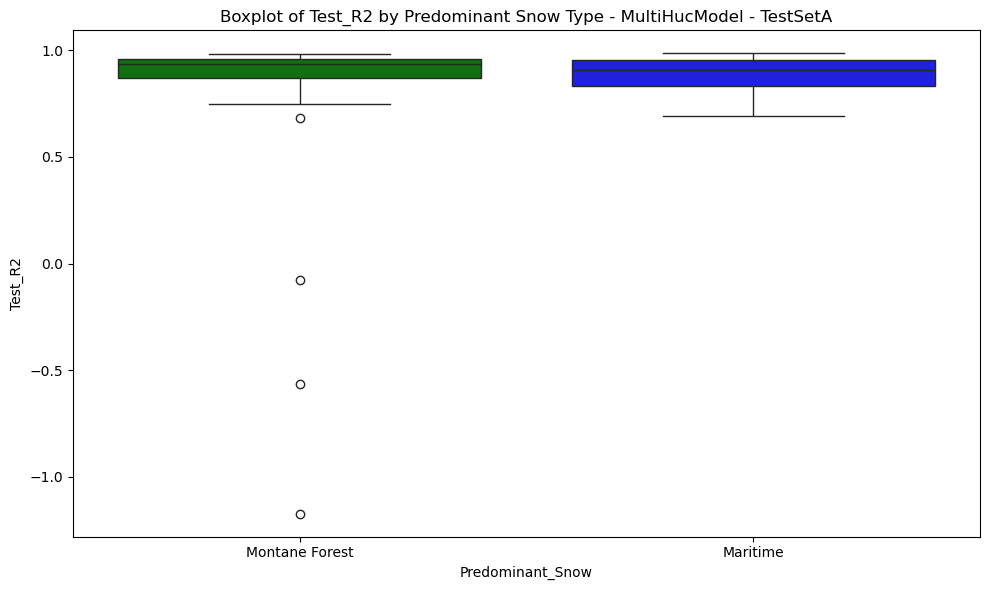

In [24]:

parameter = "Test_R2"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel - TestSetA"
color_map = {"Montane Forest": "green", "Maritime": "blue"}
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

In [22]:
p_values = pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Maritime,Montane Forest,0.210298
1,Maritime,Prairie,0.013274
2,Montane Forest,Prairie,0.032031


# Step 6 Examine by Elevation 

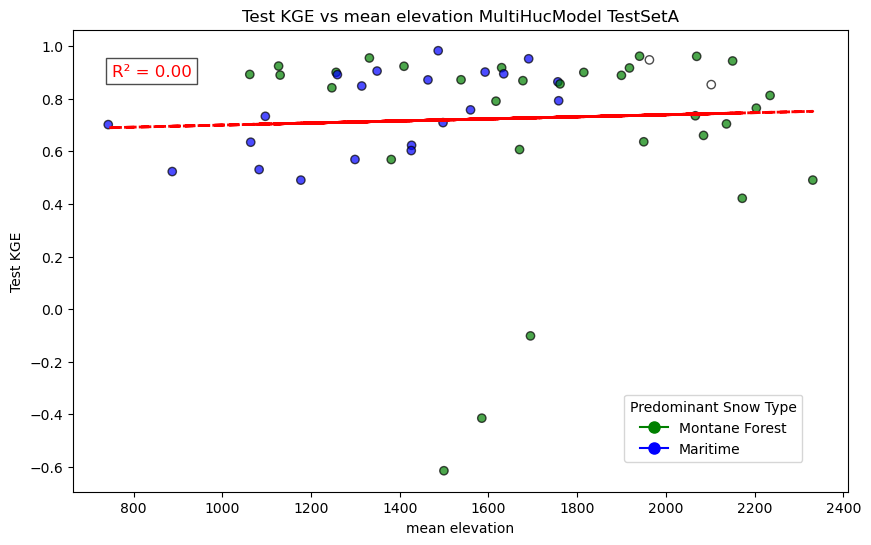

In [23]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_MultiHucModel_TestSetA"
plot_scatter_w_R2(df_metrics, x_var_name, y_var_name, color_map_snow, title = ttl)